## This notebook compares concordance of centrolign SVs and horhap derived SVs using windows  

In [24]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn

In [25]:
# Read in list of pairwise distances per chromosome

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [26]:
## This function reads in the concordance bed files 

def read_beds(folder_path, suffix):
    """
    Reads all BED files ending with 'triangles.100bp.bed' in the given folder
    and combines them into a single DataFrame with a calculated 'ratio' column.
    
    Parameters:
        folder_path (str): Path to the folder containing BED files.
        
    Returns:
        pd.DataFrame: Combined DataFrame with columns:
                      ['sample', 'window_start', 'window_end', 'centrolign_counts', 'horhap_counts', 'ratio']
    """
    
    all_dfs = []
    
    # Loop through files in folder
    for filename in os.listdir(folder_path):
        if filename.endswith(suffix):
            file_path = os.path.join(folder_path, filename)
            
            # Read the BED file
            df = pd.read_csv(
                file_path,
                sep="\t",            # assuming tab-delimited
                header=None,
                names=["sample", "window_start", "window_end", "centrolign_counts", "horhap_counts"]
            )
            # Determine the "other" sample in the file
            unique_samples = df["sample"].unique()
            if len(unique_samples) == 1:
                # Only one sample, set sample2 to None
                df["sample2"] = None
            else:
                # Create a mapping from sample to the other sample
                sample_map = {s: [o for o in unique_samples if o != s][0] for s in unique_samples}
                df["sample2"] = df["sample"].map(sample_map)
            
            # Compute ratio safely
            df["ratio"] = df.apply(
                lambda row: row["centrolign_counts"] / row["horhap_counts"]
                if row["centrolign_counts"] != 0 and row["horhap_counts"] != 0
                else 0,
                axis=1
            )
            
            all_dfs.append(df)
    
    # Concatenate all DataFrames
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        # Return empty DataFrame with correct columns if no files found
        return pd.DataFrame(columns=["sample","sample2", "window_start", "window_end", 
                                     "centrolign_counts", "horhap_counts", "ratio"])


### 100bp windows, just triangles. Plotting each window separately

In [27]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "triangles.100bp.bed"
df = read_beds(folder,suffix)
df["chr"]="chr12"
print(df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00290.1      34653281    34657558               4077              0   
1  HG00290.1      34680631    34681867                  0           1036   
2  HG00290.1      34727166    34749346              14598          15621   
3  HG00290.1      34750258    34784073              21054          24337   
4  HG00290.1      34795428    34807027               7813           7492   

     sample2     ratio    chr  
0  HG01358.1  0.000000  chr12  
1  HG01358.1  0.000000  chr12  
2  HG01358.1  0.934511  chr12  
3  HG01358.1  0.865103  chr12  
4  HG01358.1  1.042846  chr12  


In [28]:
## merge with all pairs distances 

df = df.rename(columns={"sample": "sample1"})

merged = (
    df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist
0,HG00290.1,34653281,34657558,4077,0,HG01358.1,0.000000,chr12,0.513215
1,HG00290.1,34680631,34681867,0,1036,HG01358.1,0.000000,chr12,0.513215
2,HG00290.1,34727166,34749346,14598,15621,HG01358.1,0.934511,chr12,0.513215
3,HG00290.1,34750258,34784073,21054,24337,HG01358.1,0.865103,chr12,0.513215
4,HG00290.1,34795428,34807027,7813,7492,HG01358.1,1.042846,chr12,0.513215


In [29]:
denom = merged["centrolign_counts"] + merged["horhap_counts"]

merged["cen_prop"] = np.where(
    denom > 0,
    df["centrolign_counts"] / denom,
    0
)
merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00290.1,34653281,34657558,4077,0,HG01358.1,0.000000,chr12,0.513215,1.000000
1,HG00290.1,34680631,34681867,0,1036,HG01358.1,0.000000,chr12,0.513215,0.000000
2,HG00290.1,34727166,34749346,14598,15621,HG01358.1,0.934511,chr12,0.513215,0.483074
3,HG00290.1,34750258,34784073,21054,24337,HG01358.1,0.865103,chr12,0.513215,0.463836
4,HG00290.1,34795428,34807027,7813,7492,HG01358.1,1.042846,chr12,0.513215,0.510487


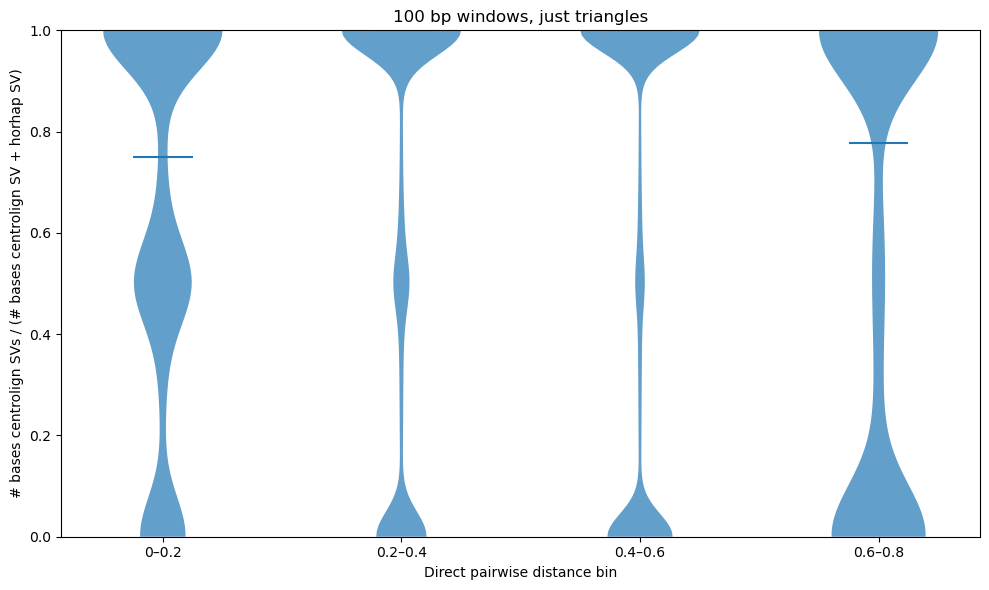

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SV)")
plt.title("100 bp windows, just triangles")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### 100 bp windows, all SVs. Plotting concordance for each window separately 

In [31]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "all_SVs.100bp.bed"
df = read_beds(folder,suffix)
df["chr"]="chr12"
print(df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG01109.1      34766195    34767754               1359              0   
1  HG01109.1      34867956    34869193                  0           1037   
2  HG01109.1      34872067    34875664               3397              0   
3  HG01109.1      34897963    34905639               7476              0   
4  HG01109.1      34913485    34917082               3397              0   

     sample2  ratio    chr  
0  HG01940.2    0.0  chr12  
1  HG01940.2    0.0  chr12  
2  HG01940.2    0.0  chr12  
3  HG01940.2    0.0  chr12  
4  HG01940.2    0.0  chr12  


In [32]:
## merge with all pairs distances 

df = df.rename(columns={"sample": "sample1"})

merged = (
    df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

merged.head()

denom = merged["centrolign_counts"] + merged["horhap_counts"]

merged["cen_prop"] = np.where(
    denom > 0,
    df["centrolign_counts"] / denom,
    0
)
merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG01109.1,34766195,34767754,1359,0,HG01940.2,0.0,chr12,0.23066,1.0
1,HG01109.1,34867956,34869193,0,1037,HG01940.2,0.0,chr12,0.23066,0.0
2,HG01109.1,34872067,34875664,3397,0,HG01940.2,0.0,chr12,0.23066,1.0
3,HG01109.1,34897963,34905639,7476,0,HG01940.2,0.0,chr12,0.23066,1.0
4,HG01109.1,34913485,34917082,3397,0,HG01940.2,0.0,chr12,0.23066,1.0


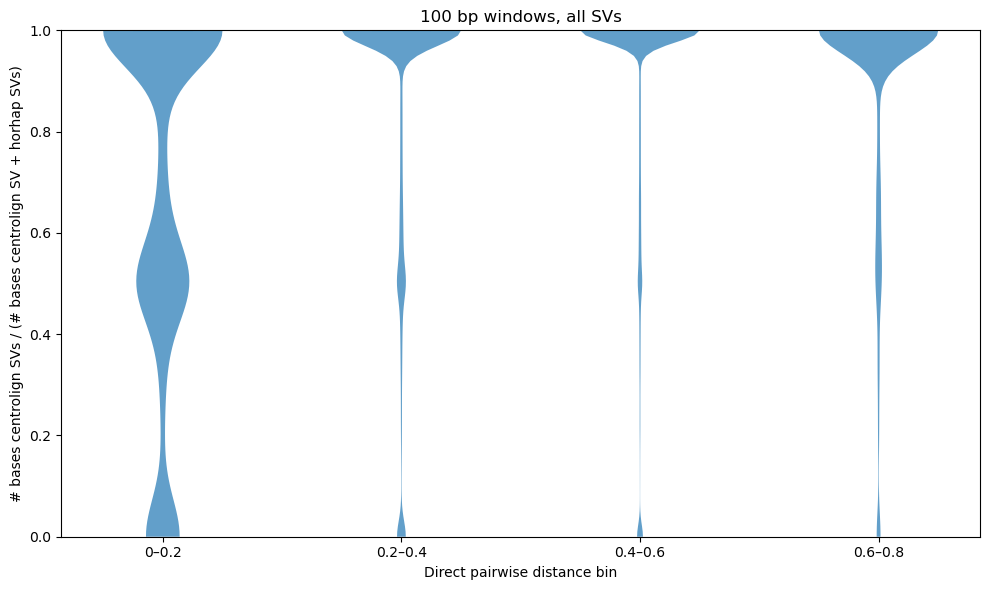

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Only the first 4 bins
bins = [0.0, 0.2, 0.4, 0.6, 0.8]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8"]

df = merged.copy()

df["dist_bin"] = pd.cut(
    df["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

df_plot = df.dropna(subset=["dist_bin", "cen_prop"])

data_per_bin = [
    df_plot.loc[df_plot["dist_bin"] == label, "cen_prop"].values
    for label in labels
]
plt.figure(figsize=(10, 6))

vp = plt.violinplot(
    data_per_bin,
    positions=np.arange(len(labels)),
    showmeans=False,
    showmedians=True,
    showextrema=False
)

# Style violins
for body in vp["bodies"]:
    body.set_alpha(0.7)

plt.xticks(np.arange(len(labels)), labels)
plt.xlabel("Direct pairwise distance bin")
plt.ylabel("# bases centrolign SVs / (# bases centrolign SV + horhap SVs)")
plt.title("100 bp windows, all SVs")

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [34]:
### Calculate the average concordance per sample 

# create an order-independent pair column
merged["sample_pair"] = merged.apply(
    lambda r: tuple(sorted([r["sample1"], r["sample2"]])),
    axis=1
)

# group by the unordered pair and calculate mean cen_prop
avg_cen_prop = (
    merged.groupby("sample_pair", as_index=False)
      .agg(
          avg_cen_prop=("cen_prop", "mean"),
          direct_pairwise_dist=("direct_pairwise_dist", "first")
      )
)
print(avg_cen_prop)


                 sample_pair  avg_cen_prop  direct_pairwise_dist
0     (HG00099.1, HG00126.2)      0.914358              0.534728
1     (HG00099.1, HG00128.1)      0.678380              0.118052
2     (HG00099.1, HG00133.1)      0.559595              0.042255
3     (HG00099.1, HG00140.2)      0.695287              0.121332
4     (HG00099.1, HG00232.2)      0.887120              0.407784
...                      ...           ...                   ...
1480  (NA20905.1, NA21106.1)      0.874201              0.415930
1481  (NA20905.1, NA21106.2)      0.888610              0.373868
1482  (NA21102.2, NA21106.1)      0.890398              0.424940
1483  (NA21102.2, NA21106.2)      0.685495              0.136764
1484  (NA21106.1, NA21106.2)      0.896082              0.396133

[1485 rows x 3 columns]


/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 33.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/private/home/mmastora/miniconda3/envs/ipynb/lib/python3.14/site-packages/seaborn/categorical.py:3399: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


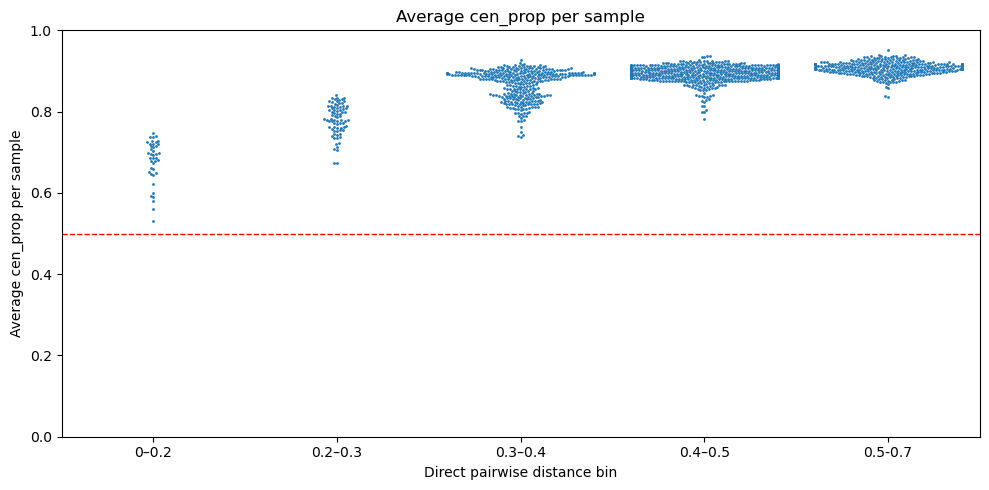

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bins = [0.0, 0.2, 0.3, 0.4, 0.5, 0.7]
labels = ["0–0.2", "0.2–0.3", "0.3–0.4", "0.4–0.5", "0.5-0.7"]

avg_cen_prop["dist_bin"] = pd.cut(
    avg_cen_prop["direct_pairwise_dist"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

plt.figure(figsize=(10, 5))
sns.swarmplot(
    data=avg_cen_prop,
    x="dist_bin",
    y="avg_cen_prop",
    size=2
)

# horizontal reference line at y = 0.5
plt.axhline(
    y=0.5,
    color="red",
    linestyle="--",
    linewidth=1
)
plt.xlabel("Direct pairwise distance bin")
plt.ylim(0,1)
plt.ylabel("Average cen_prop per sample")
plt.title("Average cen_prop per sample")
plt.tight_layout()
plt.show()


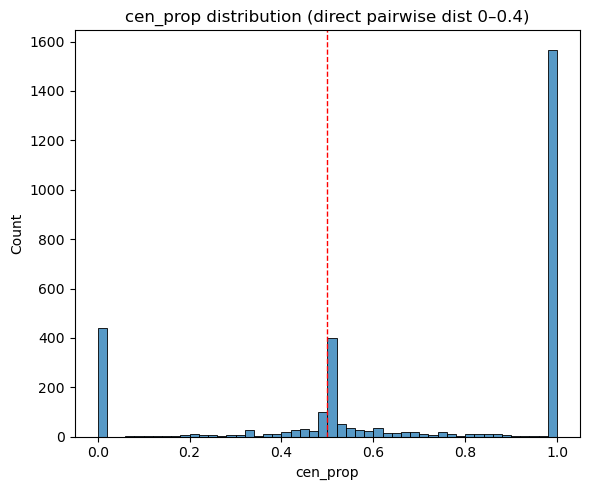

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_0_04 = merged[
    (merged["direct_pairwise_dist"] >= 0.0) &
    (merged["direct_pairwise_dist"] < 0.2)
]

plt.figure(figsize=(6, 5))
sns.histplot(
    data=df_0_04,
    x="cen_prop",
    bins=50
)

plt.axvline(
    0.5,
    color="red",
    linestyle="--",
    linewidth=1
)

plt.xlabel("cen_prop")
plt.ylabel("Count")
plt.title("cen_prop distribution (direct pairwise dist 0–0.4)")
plt.tight_layout()
plt.show()




### 1000 bp windows, all SVs 

In [22]:
folder = "/private/groups/patenlab/mira/centrolign/analysis/horhap_SV_concordance/chr12/cenhap4"
suffix = "all_SVs.1000bp.bed"
df = read_beds(folder,suffix)
df["chr"]="chr12"
print(df.head())

      sample  window_start  window_end  centrolign_counts  horhap_counts  \
0  HG00126.2      34708991    34715618                  0              0   
1  HG00126.2      34719721    34727491                  0              0   
2  HG00126.2      34735738    34745966                  0              0   
3  HG00126.2      34747038    34757342                  0              1   
4  HG00126.2      34758052    34760538                  0              0   

     sample2  ratio    chr  
0  HG00329.2    0.0  chr12  
1  HG00329.2    0.0  chr12  
2  HG00329.2    0.0  chr12  
3  HG00329.2    0.0  chr12  
4  HG00329.2    0.0  chr12  


In [23]:
## merge with all pairs distances 

df = df.rename(columns={"sample": "sample1"})

merged = (
    df
    .merge(all_pairs_dist_df, on=["sample1", "sample2","chr"], how="left")
)

merged.head()

denom = merged["centrolign_counts"] + merged["horhap_counts"]

merged["cen_prop"] = np.where(
    denom > 0,
    df["centrolign_counts"] / denom,
    0
)
merged.head()

,sample1,window_start,window_end,centrolign_counts,horhap_counts,sample2,ratio,chr,direct_pairwise_dist,cen_prop
0,HG00126.2,34708991,34715618,0,0,HG00329.2,0.0,chr12,0.562033,0.0
1,HG00126.2,34719721,34727491,0,0,HG00329.2,0.0,chr12,0.562033,0.0
2,HG00126.2,34735738,34745966,0,0,HG00329.2,0.0,chr12,0.562033,0.0
3,HG00126.2,34747038,34757342,0,1,HG00329.2,0.0,chr12,0.562033,0.0
4,HG00126.2,34758052,34760538,0,0,HG00329.2,0.0,chr12,0.562033,0.0
